In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tinyquickdraw/helmet.ndjson
/kaggle/input/tinyquickdraw/baseball bat.ndjson
/kaggle/input/tinyquickdraw/hexagon.ndjson
/kaggle/input/tinyquickdraw/hockey stick.ndjson
/kaggle/input/tinyquickdraw/finger.ndjson
/kaggle/input/tinyquickdraw/quickdraw_simplified/angel.ndjson
/kaggle/input/tinyquickdraw/quickdraw_simplified/bush.ndjson
/kaggle/input/tinyquickdraw/quickdraw_simplified/calendar.ndjson
/kaggle/input/tinyquickdraw/quickdraw_simplified/cactus.ndjson
/kaggle/input/tinyquickdraw/quickdraw_simplified/anvil.ndjson
/kaggle/input/tinyquickdraw/quickdraw_simplified/yoga.ndjson
/kaggle/input/tinyquickdraw/quickdraw_simplified/moustache.ndjson
/kaggle/input/tinyquickdraw/quickdraw_simplified/headphones.ndjson
/kaggle/input/tinyquickdraw/quickdraw_simplified/saw.ndjson
/kaggle/input/tinyquickdraw/quickdraw_simplified/pencil.ndjson
/kaggle/input/tinyquickdraw/quickdraw_simplified/elbow.ndjson
/kaggle/input/tinyquickdraw/quickdraw_simplified/windmill.ndjson
/kaggle/input/tinyqu

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Path to sketches folder
SKETCHES_FOLDER = '/kaggle/input/tinyquickdraw/sketches/sketches'

# List the first 50 .npz files (classes)
all_npz_files = sorted([f for f in os.listdir(SKETCHES_FOLDER) if f.endswith('.npz')])
selected_npz_files = all_npz_files[:50]
print("Total selected classes:", len(selected_npz_files))
print("Selected classes:", selected_npz_files)

# Loop over each selected file and display details
for idx, class_file in enumerate(selected_npz_files, 1):
    file_path = os.path.join(SKETCHES_FOLDER, class_file)
    data = np.load(file_path, allow_pickle=True, encoding='latin1')
    
    print(f"\n[{idx}] Class: {class_file.replace('.npz', '')}")
    print("Keys:", data.files)
    
    for split in ['train', 'valid', 'test']:
        if split in data:
            print(f"  {split.capitalize()} shape: {data[split].shape}")


Total selected classes: 50
Selected classes: ['The Eiffel Tower.npz', 'The Great Wall of China.npz', 'The Mona Lisa.npz', 'aircraft carrier.npz', 'airplane.npz', 'alarm clock.npz', 'ambulance.npz', 'angel.npz', 'animal migration.npz', 'ant.npz', 'anvil.npz', 'apple.npz', 'arm.npz', 'asparagus.npz', 'axe.npz', 'backpack.npz', 'banana.npz', 'bandage.npz', 'barn.npz', 'baseball bat.npz', 'baseball.npz', 'basket.npz', 'basketball.npz', 'bat.npz', 'bathtub.npz', 'beach.npz', 'bear.npz', 'beard.npz', 'bed.npz', 'bee.npz', 'belt.npz', 'bench.npz', 'bicycle.npz', 'binoculars.npz', 'bird.npz', 'birthday cake.npz', 'blackberry.npz', 'blueberry.npz', 'book.npz', 'boomerang.npz', 'bottlecap.npz', 'bowtie.npz', 'bracelet.npz', 'brain.npz', 'bread.npz', 'bridge.npz', 'broccoli.npz', 'broom.npz', 'bucket.npz', 'bulldozer.npz']

[1] Class: The Eiffel Tower
Keys: ['test', 'train', 'valid']
  Train shape: (70000,)
  Valid shape: (2500,)
  Test shape: (2500,)

[2] Class: The Great Wall of China
Keys: ['t

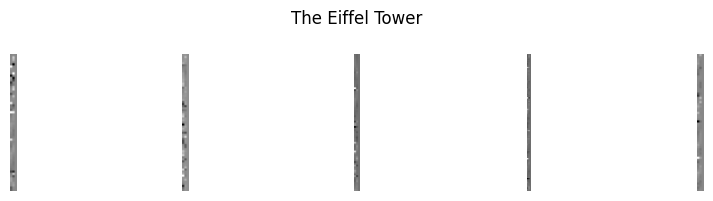

In [7]:
# 3. Visualize a few samples from each class
def plot_sketches(sketches, num=5, title='Sketch'):
    plt.figure(figsize=(10, 2))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.imshow(sketches[i], cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

train_sketches = data['train']
plot_sketches(train_sketches, num=5, title=selected_npz_files[0].replace('.npz', ''))


Sample shape: (49, 3)


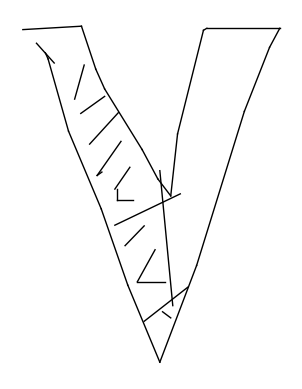

In [8]:
def draw_sketch(sketch):
    """
    Draws a sketch from a stroke-3 format array of shape (n, 3).
    """
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.axis('off')

    x, y = 0, 0
    for dx, dy, pen in sketch:
        new_x, new_y = x + dx, y + dy
        if pen == 0:  # pen down, draw a line
            ax.plot([x, new_x], [y, new_y], 'k-', linewidth=1)
        x, y = new_x, new_y

    plt.show()

# Example usage — assuming your dataset contains vector format:
file_path = os.path.join(SKETCHES_FOLDER, selected_npz_files[0])
data = np.load(file_path, allow_pickle=True, encoding='latin1')

if 'train' in data:
    # Make sure this is vector format, not 28x28 images
    sample_sketch = data['train'][10]
    print("Sample shape:", sample_sketch.shape)
    draw_sketch(sample_sketch)


Loaded 70000 sketches for class The Eiffel Tower
Sample sketch shape: (28, 3)


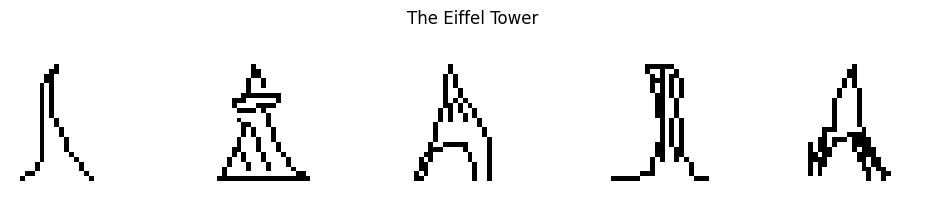

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# --- 1. Stroke-3 → Image conversion ---
def sketch_to_image(sketch, image_size=28, padding=2):
    """
    Converts a stroke-3 sketch to a 28x28 grayscale image.
    sketch: (n_points, 3) numpy array (dx, dy, pen_state)
    image_size: output image size (default 28)
    padding: white border size around the sketch
    Returns: 28x28 numpy array (float32, values in [0,1])
    """
    # Convert relative to absolute coordinates
    x, y = 0, 0
    abs_coords = []
    for dx, dy, pen in sketch:
        x += dx
        y += dy
        abs_coords.append((x, y, pen))
    
    # Separate strokes into continuous pen-down segments
    strokes = []
    current_stroke = []
    for x, y, pen in abs_coords:
        if pen == 0:  # pen down
            current_stroke.append((x, y))
        elif pen == 1:  # pen up
            if current_stroke:
                strokes.append(current_stroke)
                current_stroke = []
        elif pen == 2:  # end of drawing
            break
    if current_stroke:
        strokes.append(current_stroke)
    
    # Bounding box
    all_points = [pt for stroke in strokes for pt in stroke]
    xs, ys = zip(*all_points)
    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)
    
    # Scale to fit in the target size
    scale = (image_size - 2 * padding) / max(max_x - min_x, max_y - min_y + 1e-5)
    
    # Create blank white image and draw strokes
    img = Image.new('L', (image_size, image_size), 'white')  # L = grayscale
    draw = ImageDraw.Draw(img)
    for stroke in strokes:
        scaled = [((x - min_x) * scale + padding, (y - min_y) * scale + padding) for x, y in stroke]
        draw.line(scaled, fill=0, width=1)
    
    return np.array(img, dtype=np.float32) / 255.0


# --- 2. Load one vector dataset file ---

all_npz_files = sorted([f for f in os.listdir(SKETCHES_FOLDER) if f.endswith('.npz')])

sample_file = os.path.join(SKETCHES_FOLDER, all_npz_files[0])
data = np.load(sample_file, allow_pickle=True, encoding='latin1')

# Ensure we're working with vector data
train_sketches = data['train']
print(f"Loaded {train_sketches.shape[0]} sketches for class {all_npz_files[0].replace('.npz', '')}")
print("Sample sketch shape:", train_sketches[0].shape)


# --- 3. Convert and plot first few sketches ---
plt.figure(figsize=(10, 2))
for i in range(5):
    img = sketch_to_image(train_sketches[i])
    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.suptitle(all_npz_files[0].replace('.npz', ''))
plt.tight_layout()
plt.show()


In [10]:

from sklearn.model_selection import train_test_split

def load_and_preprocess_data(sketches_folder, selected_classes, samples_per_class=1000):
    X, y = [], []
    for class_idx, class_file in enumerate(selected_classes):
        data = np.load(os.path.join(sketches_folder, class_file), 
                       allow_pickle=True, encoding='latin1')
        sketches = data['train']
        for i in range(min(samples_per_class, len(sketches))):
            img = sketch_to_image(sketches[i])
            X.append(img)
            y.append(class_idx)
    X = np.array(X).reshape(-1, 28, 28, 1)
    y = np.array(y)
    return X, y

# --- Kaggle dataset path ---
all_npz_files = sorted([f for f in os.listdir(SKETCHES_FOLDER) if f.endswith('.npz')])
selected_npz_files = all_npz_files[:50]

# --- Load data ---
X, y = load_and_preprocess_data(SKETCHES_FOLDER, selected_npz_files, samples_per_class=1000)

# --- Train/Validation split ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Dataset info ---
print("Dataset shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")

print("\nClass distribution in training set:")
unique, counts = np.unique(y_train, return_counts=True)
for class_idx, count in zip(unique, counts):
    print(f"{selected_npz_files[class_idx]}: {count}")

Dataset shapes:
X_train: (40000, 28, 28, 1)
X_val: (10000, 28, 28, 1)
y_train: (40000,)
y_val: (10000,)

Class distribution in training set:
The Eiffel Tower.npz: 800
The Great Wall of China.npz: 800
The Mona Lisa.npz: 800
aircraft carrier.npz: 800
airplane.npz: 800
alarm clock.npz: 800
ambulance.npz: 800
angel.npz: 800
animal migration.npz: 800
ant.npz: 800
anvil.npz: 800
apple.npz: 800
arm.npz: 800
asparagus.npz: 800
axe.npz: 800
backpack.npz: 800
banana.npz: 800
bandage.npz: 800
barn.npz: 800
baseball bat.npz: 800
baseball.npz: 800
basket.npz: 800
basketball.npz: 800
bat.npz: 800
bathtub.npz: 800
beach.npz: 800
bear.npz: 800
beard.npz: 800
bed.npz: 800
bee.npz: 800
belt.npz: 800
bench.npz: 800
bicycle.npz: 800
binoculars.npz: 800
bird.npz: 800
birthday cake.npz: 800
blackberry.npz: 800
blueberry.npz: 800
book.npz: 800
boomerang.npz: 800
bottlecap.npz: 800
bowtie.npz: 800
bracelet.npz: 800
brain.npz: 800
bread.npz: 800
bridge.npz: 800
broccoli.npz: 800
broom.npz: 800
bucket.npz: 800


In [11]:
# --- CNN model ---
import tensorflow as tf
from tensorflow.keras import layers, models

def create_sketch_classifier(input_shape=(28, 28, 1), num_classes=50):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Flatten(),
        layers.Dense(512),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# --- Training helper ---
def compile_and_train(model, X_train, y_train, X_val, y_val):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
        ]
    )
    return history


In [12]:
model = create_sketch_classifier(num_classes=50)  # 10 classes as per selected_npz_files
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │        25,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 711,602 (2.71 MB)

 Trainable params: 710,130 (2.71 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [13]:
history = compile_and_train(model, X_train, y_train, X_val, y_val)


Epoch 1/30


I0000 00:00:1754995134.828312      99 service.cc:148] XLA service 0x7a5da40079a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754995134.829111      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754995134.829136      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754995135.309155      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


 30/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0280 - loss: 4.4434     

I0000 00:00:1754995140.451313      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.2155 - loss: 3.1572 - val_accuracy: 0.4213 - val_loss: 2.1990 - learning_rate: 0.0010
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4744 - loss: 1.9400 - val_accuracy: 0.5829 - val_loss: 1.5440 - learning_rate: 0.0010
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5478 - loss: 1.6576 - val_accuracy: 0.6399 - val_loss: 1.3449 - learning_rate: 0.0010
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5810 - loss: 1.5048 - val_accuracy: 0.6378 - val_loss: 1.3415 - learning_rate: 0.0010
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6139 - loss: 1.3957 - val_accuracy: 0.6433 - val_loss: 1.3168 - learning_rate: 0.0010
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6294 - loss: 1.3177 - val_accuracy: 0.6888 - val_loss: 1.1615 - learning_rate: 0.0010
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6421 - loss: 1.2610 - val_accura

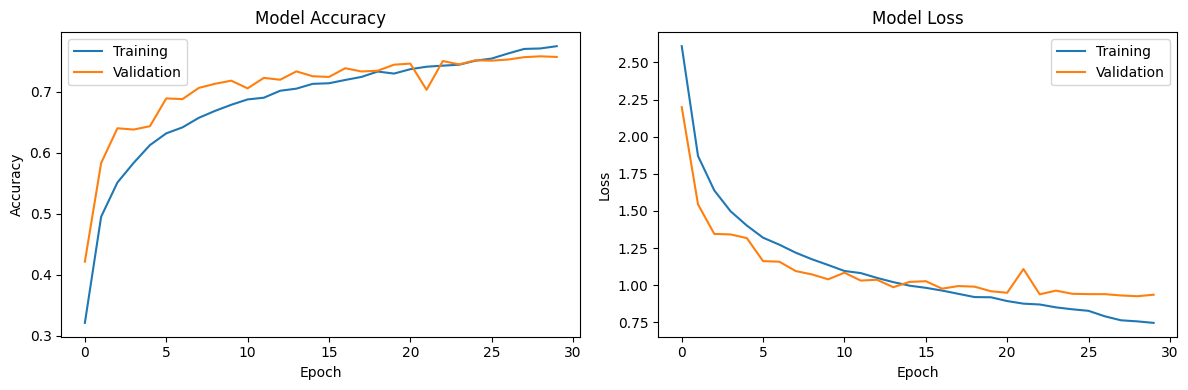

In [14]:

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Model Evaluation:
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Test Accuracy: 0.7578


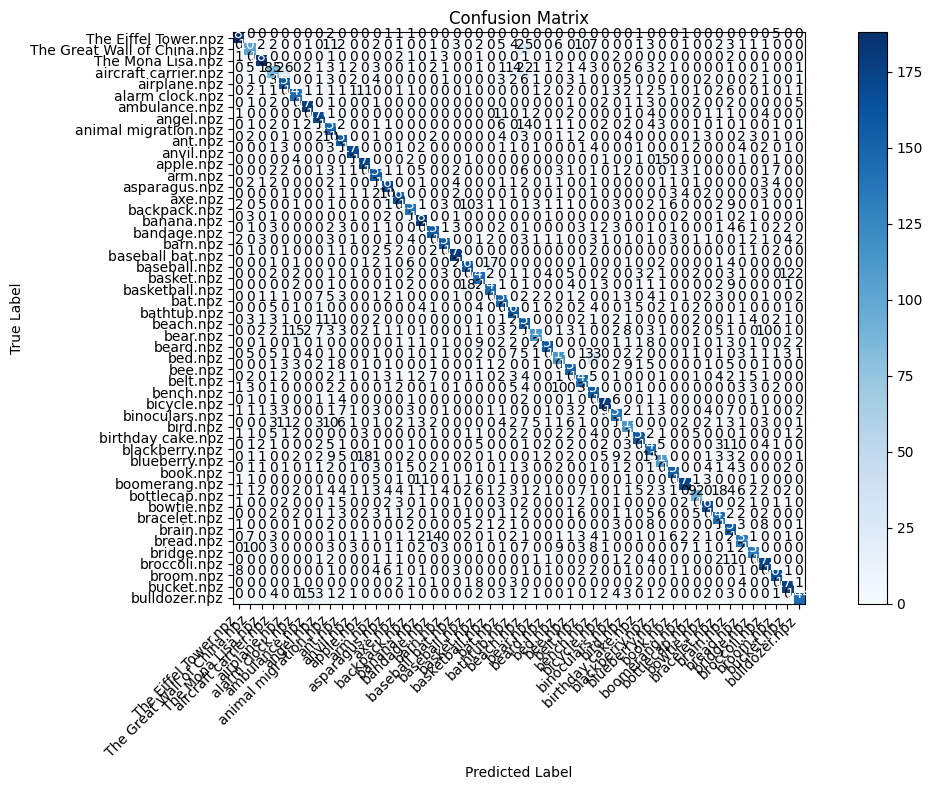


Classification Report:
                         precision    recall  f1-score   support

       The Eiffel Tower       0.90      0.94      0.92       200
The Great Wall of China       0.64      0.52      0.57       200
          The Mona Lisa       0.88      0.92      0.90       200
       aircraft carrier       0.56      0.42      0.48       200
               airplane       0.72      0.79      0.75       200
            alarm clock       0.77      0.72      0.75       200
              ambulance       0.86      0.89      0.88       200
                  angel       0.81      0.85      0.83       200
       animal migration       0.56      0.75      0.64       200
                    ant       0.70      0.79      0.74       200
                  anvil       0.89      0.85      0.87       200
                  apple       0.81      0.86      0.84       200
                    arm       0.75      0.77      0.76       200
              asparagus       0.78      0.84      0.81       200


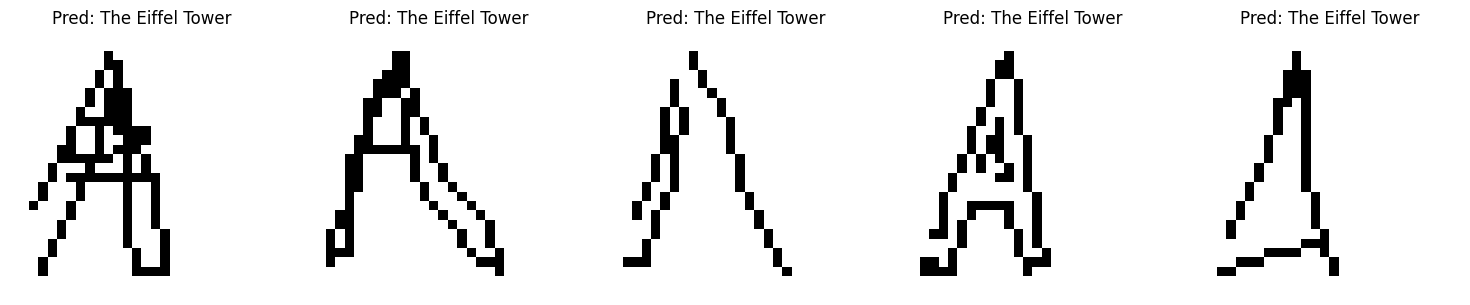

In [15]:
def evaluate_model(model, X_test, y_test, class_names):
    """
    Comprehensive model evaluation
    """
    # Get model predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Calculate accuracy
    test_accuracy = np.mean(y_pred_classes == y_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Confusion Matrix
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(y_test, y_pred_classes)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(12, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    # Add class labels
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)
    
    # Add numbers to confusion matrix
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes, 
                              target_names=[name.replace('.npz', '') for name in class_names]))

# Test with unseen data
def test_with_unseen_data(model, sketches_folder, class_name, num_samples=5):
    """
    Test model with unseen data from a specific class
    """
    # Load test data
    data = np.load(os.path.join(sketches_folder, class_name), 
                  allow_pickle=True, encoding='latin1')
    test_sketches = data['test'][:num_samples]
    
    # Convert sketches to images
    test_images = []
    for sketch in test_sketches:
        img = sketch_to_image(sketch)
        test_images.append(img)
    
    # Convert to numpy array and reshape
    X_test_unseen = np.array(test_images).reshape(-1, 28, 28, 1)
    
    # Get predictions
    predictions = model.predict(X_test_unseen)
    pred_classes = np.argmax(predictions, axis=1)
    
    # Plot results
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(test_images[i], cmap='gray')
        plt.title(f'Pred: {selected_npz_files[pred_classes[i]].replace(".npz", "")}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Evaluate the model
print("Model Evaluation:")
evaluate_model(model, X_val, y_val, selected_npz_files)

# Test with unseen data from a specific class
print("\nTesting with unseen data:")
test_with_unseen_data(model, SKETCHES_FOLDER, selected_npz_files[0])  # Test first class

In [16]:

# Save the trained model
model_save_path = 'sketch_classifier.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to sketch_classifier.h5
